Original code from https://github.com/YudiDong/Channel_Estimation_cGAN/
This repository above describes the implementation of the paper: 
Yudi Dong, Huaxia Wang, and Yu-Dong Yao, “Channel Estimation for One-Bit Multiuser Massive MIMO Using Conditional GAN.” ArXiv:2006.11435 [Eess], June 2020. arXiv.org, http://arxiv.org/abs/2006.11435.
IEEE Communications Letters, 2020.

In [2]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from files_10_channel.cGANGenerator import Generator
from files_10_channel.cGANDiscriminator import Discriminator
from files_10_channel.data_preprocess import load_image_train, load_image_test, load_image_test_y
from tempfile import TemporaryFile
from scipy.io import loadmat, savemat
import datetime
import h5py
#import hdf5storage
#import skfuzzy as fuzz
from scipy.linalg import norm

In [3]:
%matplotlib inline
#plot inside Jupyter notebook
#Read more at https://stackoverflow.com/questions/43027980/purpose-of-matplotlib-inline

In [4]:
# GPU Setting
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.enable_eager_execution(config=config)
layers = tf.keras.layers

In [5]:
# data path
#path = "../Data_Generation/Gan_Data/Gan_0_dBIndoor2p4_64ant_32users_8pilot.mat" #original path
path = "./files_10_channel/cgan_data/Gan_0_dBIndoor2p4_64ant_32users_8pilot.mat"

# batch = 1 produces good results on U-NET
BATCH_SIZE = 1              

In [6]:
# model
generator = Generator()
discriminator = Discriminator()
# optimizer
generator_optimizer = tf.compat.v1.train.AdamOptimizer(2e-4, beta1=0.5)
discriminator_optimizer = tf.compat.v1.train.RMSPropOptimizer(2e-5)
#discriminator_optimizer = tf.compat.v1.train.AdamOptimizer(2e-4, beta1=0.5)

In [7]:
'''
Average NMSE as Frobenius norms.
Calculate for a 4D tensor such as
(664, 64, 32, 2)
by first converting the matrices into complex-valued matrices.
Aldebaro, Sep. 2022
'''
def nmse_average(y_true, y_pred):
    num_matrices, N, M, realimag = y_true.shape
    assert(realimag == 2)
    all_nmses = np.zeros(num_matrices,)
    for i in range(num_matrices):
        #convert to complex matrices
        true_matrix = np.empty( (N,M), dtype=np.complex128)
        true_matrix.real = y_true[i,:,:,0]
        true_matrix.imag = y_true[i,:,:,1]

        pred_matrix = np.empty( (N,M), dtype=np.complex128)
        pred_matrix.real = y_pred[i,:,:,0]
        pred_matrix.imag = y_pred[i,:,:,1]

        error = true_matrix - pred_matrix
        numerator = norm(error, ord='fro') ** 2
        denominator = norm(true_matrix, ord='fro') ** 2
        if denominator == 0 and numerator == 0:
            all_nmses[i] = 0
        else:
            all_nmses[i] = numerator / denominator
    return np.mean(all_nmses)

In [8]:
"""
Discriminator loss:
The discriminator loss function takes 2 inputs; real images, generated images
real_loss is a sigmoid cross entropy loss of the real images and an array of ones(since the real images)
generated_loss is a sigmoid cross entropy loss of the generated images and an array of zeros(since the fake images)
Then the total_loss is the sum of real_loss and the generated_loss
"""
def discriminator_loss(disc_real_output, disc_generated_output):
    """disc_real_output = [real_target]
       disc_generated_output = [generated_target]
    """
    real_loss = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.ones_like(disc_real_output), logits=disc_real_output)  # label=1
    generated_loss = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.zeros_like(disc_generated_output), logits=disc_generated_output)  # label=0
    total_disc_loss = tf.reduce_mean(real_loss) + tf.reduce_mean(generated_loss)
    return total_disc_loss


In [9]:
"""
Generator loss:
It is a sigmoid cross entropy loss of the generated images and an array of ones.
The paper also includes L2 loss between the generated image and the target image.
This allows the generated image to become structurally similar to the target image.
The formula to calculate the total generator loss = gan_loss + LAMBDA * l2_loss, where LAMBDA = 100. 
This value was decided by the authors of the paper.
"""
def generator_loss(disc_generated_output, gen_output, target, l2_weight=100):
    """
        disc_generated_output: output of Discriminator when input is from Generator
        gen_output:  output of Generator (i.e., estimated H)
        target:  target image
        l2_weight: weight of L2 loss
    """
    # GAN loss
    gen_loss = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.ones_like(disc_generated_output), logits=disc_generated_output)
    # L2 loss
    l2_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = tf.reduce_mean(gen_loss) + l2_weight * l2_loss
    return total_gen_loss

In [10]:
def generated_image(model, test_input, tar, t=0):
    """Dispaly  the results of Generator"""
    prediction = model(test_input)
    #plt.figure(figsize=(15, 15))
    display_list = [np.squeeze(test_input[:,:,:,0]), np.squeeze(tar[:,:,:,0]), np.squeeze(prediction[:,:,:,0])]
    

    title = ['Input Y', 'Target H', 'Prediction H']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]) 
        plt.axis("off")
    plt.savefig(os.path.join("generated_img", "img_"+str(t)+".png"))

In [11]:
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image)                      # input -> generated_target
        disc_real_output = discriminator(target)  # [input, target] -> disc output
        disc_generated_output = discriminator(gen_output)  # [input, generated_target] -> disc output
        # print("*", gen_output.shape, disc_real_output.shape, disc_generated_output.shape)

        # calculate loss
        gen_loss = generator_loss(disc_generated_output, gen_output, target)   # gen loss
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)  # disc loss

    # gradient
    generator_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # apply gradient
    generator_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradient, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [12]:
def train(epochs):
    nm = []
    ep = []
    start_time = datetime.datetime.now()
    for epoch in range(epochs):
        print("-----\nEPOCH:", epoch)
        # train
        for bi, (target, input_image) in enumerate(load_image_train(path)):
            elapsed_time = datetime.datetime.now() - start_time
            gen_loss, disc_loss = train_step(input_image, target)
            print("Batch/Epoch:", bi, '/' , epoch, ", Generator loss:", gen_loss.numpy(), ", Discriminator loss:", disc_loss.numpy(), ', time:',  elapsed_time)
            #AK
            #if bi > 10:
            #    break
        # generated and see the progress
        for bii, (tar, inp) in enumerate(load_image_test(path)):            
            if bii == 100:
                generated_image(generator, inp, tar, t=epoch+1  )

        # save checkpoint
        # if (epoch + 1) % 2 == 0:
        ep.append(epoch + 1)
        #generator.save_weights(os.path.join(BASE_PATH, "weights/generator_"+str(epoch)+".h5"))
        #discriminator.save_weights(os.path.join(BASE_PATH, "weights/discriminator_"+str(epoch)+".h5"))
        
        realim, inpuim = load_image_test_y(path)   
        prediction = generator(inpuim)
        
        #AK
        #nm.append(fuzz.average_nmse(np.squeeze(realim), np.squeeze(prediction)))
        nm.append(nmse_average(np.squeeze(realim), np.squeeze(prediction)))
        
        if epoch == epochs-1:
            nmse_epoch = TemporaryFile()
            np.save(nmse_epoch, nm)
        
        # Save the predicted Channel 
        matfiledata = {} # make a dictionary to store the MAT data in
        matfiledata[u'predict_Gan_0_dB_Indoor2p4_64ant_32users_8pilot'] = np.array(prediction) # *** u prefix for variable name = unicode format, no issues thru Python 3.5; advise keeping u prefix indicator format based on feedback despite docs ***
        #hdf5storage.write(matfiledata, '.', 'Results\Eest_cGAN_'+str(epoch + 1)+'_0db_Indoor2p4_64ant_32users_8pilot.mat', matlab_compatible=True)
        
        if False:
            plt.figure()
            plt.plot(ep,nm,'^-r')
            plt.xlabel('Epoch')
            plt.ylabel('NMSE')
            plt.show();
    
    return nm, ep

-----
EPOCH: 0
Batch/Epoch: 0 / 0 , Generator loss: 26.810335 , Discriminator loss: 0.5987665 , time: 0:00:00.066855
Batch/Epoch: 1 / 0 , Generator loss: 31.131304 , Discriminator loss: 0.46391633 , time: 0:00:00.711451
Batch/Epoch: 2 / 0 , Generator loss: 28.480865 , Discriminator loss: 0.5406966 , time: 0:00:00.934833
Batch/Epoch: 3 / 0 , Generator loss: 34.007824 , Discriminator loss: 0.38171166 , time: 0:00:01.156239
Batch/Epoch: 4 / 0 , Generator loss: 34.263565 , Discriminator loss: 0.3710828 , time: 0:00:01.386872
Batch/Epoch: 5 / 0 , Generator loss: 30.270172 , Discriminator loss: 0.46310928 , time: 0:00:01.608254
Batch/Epoch: 6 / 0 , Generator loss: 31.321392 , Discriminator loss: 0.3931152 , time: 0:00:01.835648
Batch/Epoch: 7 / 0 , Generator loss: 34.65442 , Discriminator loss: 0.33888927 , time: 0:00:02.059050
Batch/Epoch: 8 / 0 , Generator loss: 36.224316 , Discriminator loss: 0.34669435 , time: 0:00:02.286442
Batch/Epoch: 9 / 0 , Generator loss: 34.76436 , Discriminator l

Batch/Epoch: 80 / 0 , Generator loss: 38.526665 , Discriminator loss: 0.45858133 , time: 0:00:18.516493
Batch/Epoch: 81 / 0 , Generator loss: 34.156113 , Discriminator loss: 1.4251618 , time: 0:00:18.738898
Batch/Epoch: 82 / 0 , Generator loss: 36.693184 , Discriminator loss: 0.435794 , time: 0:00:18.963619
Batch/Epoch: 83 / 0 , Generator loss: 37.712418 , Discriminator loss: 0.45550326 , time: 0:00:19.196003
Batch/Epoch: 84 / 0 , Generator loss: 33.05882 , Discriminator loss: 1.4673699 , time: 0:00:19.418342
Batch/Epoch: 85 / 0 , Generator loss: 37.06006 , Discriminator loss: 0.60762846 , time: 0:00:19.643010
Batch/Epoch: 86 / 0 , Generator loss: 32.011692 , Discriminator loss: 0.9896099 , time: 0:00:19.869707
Batch/Epoch: 87 / 0 , Generator loss: 30.989758 , Discriminator loss: 0.7889599 , time: 0:00:20.099021
Batch/Epoch: 88 / 0 , Generator loss: 34.770287 , Discriminator loss: 0.23905618 , time: 0:00:20.324135
Batch/Epoch: 89 / 0 , Generator loss: 33.711422 , Discriminator loss: 0.

Batch/Epoch: 5 / 1 , Generator loss: 33.886353 , Discriminator loss: 0.1385556 , time: 0:00:36.701303
Batch/Epoch: 6 / 1 , Generator loss: 37.421734 , Discriminator loss: 0.67743343 , time: 0:00:36.929648
Batch/Epoch: 7 / 1 , Generator loss: 38.492977 , Discriminator loss: 0.23118126 , time: 0:00:37.149393
Batch/Epoch: 8 / 1 , Generator loss: 31.619225 , Discriminator loss: 0.08073361 , time: 0:00:37.377788
Batch/Epoch: 9 / 1 , Generator loss: 33.017788 , Discriminator loss: 0.8804652 , time: 0:00:37.600225
Batch/Epoch: 10 / 1 , Generator loss: 27.654795 , Discriminator loss: 0.6997055 , time: 0:00:37.826588
Batch/Epoch: 11 / 1 , Generator loss: 35.21936 , Discriminator loss: 0.21497025 , time: 0:00:38.054020
Batch/Epoch: 12 / 1 , Generator loss: 38.656742 , Discriminator loss: 0.09553893 , time: 0:00:38.294828
Batch/Epoch: 13 / 1 , Generator loss: 38.77138 , Discriminator loss: 0.6135014 , time: 0:00:38.516289
Batch/Epoch: 14 / 1 , Generator loss: 39.0135 , Discriminator loss: 0.45569

Batch/Epoch: 85 / 1 , Generator loss: 40.688774 , Discriminator loss: 0.45317632 , time: 0:00:54.957924
Batch/Epoch: 86 / 1 , Generator loss: 36.440044 , Discriminator loss: 0.5750827 , time: 0:00:55.187769
Batch/Epoch: 87 / 1 , Generator loss: 37.27137 , Discriminator loss: 0.29715607 , time: 0:00:55.419145
Batch/Epoch: 88 / 1 , Generator loss: 35.402813 , Discriminator loss: 0.66916996 , time: 0:00:55.657508
Batch/Epoch: 89 / 1 , Generator loss: 35.865604 , Discriminator loss: 0.10205525 , time: 0:00:55.888892
Batch/Epoch: 90 / 1 , Generator loss: 33.49533 , Discriminator loss: 0.45564747 , time: 0:00:56.113291
Batch/Epoch: 91 / 1 , Generator loss: 38.7634 , Discriminator loss: 1.42897 , time: 0:00:56.341688
Batch/Epoch: 92 / 1 , Generator loss: 31.02529 , Discriminator loss: 2.527892 , time: 0:00:56.606995
Batch/Epoch: 93 / 1 , Generator loss: 32.171192 , Discriminator loss: 1.1264443 , time: 0:00:56.836359
Batch/Epoch: 94 / 1 , Generator loss: 42.51015 , Discriminator loss: 2.20327

Batch/Epoch: 11 / 2 , Generator loss: 27.445375 , Discriminator loss: 1.9019339 , time: 0:01:13.646223
Batch/Epoch: 12 / 2 , Generator loss: 37.588875 , Discriminator loss: 0.115898594 , time: 0:01:13.866491
Batch/Epoch: 13 / 2 , Generator loss: 26.217075 , Discriminator loss: 1.0777841 , time: 0:01:14.090905
Batch/Epoch: 14 / 2 , Generator loss: 37.805344 , Discriminator loss: 0.06779215 , time: 0:01:14.315510
Batch/Epoch: 15 / 2 , Generator loss: 41.085865 , Discriminator loss: 1.8434293 , time: 0:01:14.543900
Batch/Epoch: 16 / 2 , Generator loss: 36.455196 , Discriminator loss: 0.13524058 , time: 0:01:14.767308
Batch/Epoch: 17 / 2 , Generator loss: 40.10419 , Discriminator loss: 0.7519947 , time: 0:01:14.990275
Batch/Epoch: 18 / 2 , Generator loss: 33.05546 , Discriminator loss: 0.06849013 , time: 0:01:15.219649
Batch/Epoch: 19 / 2 , Generator loss: 32.853203 , Discriminator loss: 0.20499837 , time: 0:01:15.450038
Batch/Epoch: 20 / 2 , Generator loss: 28.90468 , Discriminator loss: 

Batch/Epoch: 91 / 2 , Generator loss: 43.13499 , Discriminator loss: 0.2720142 , time: 0:01:31.812328
Batch/Epoch: 92 / 2 , Generator loss: 35.104652 , Discriminator loss: 0.61638105 , time: 0:01:32.036693
Batch/Epoch: 93 / 2 , Generator loss: 40.673447 , Discriminator loss: 0.23628032 , time: 0:01:32.264087
Batch/Epoch: 94 / 2 , Generator loss: 29.263206 , Discriminator loss: 1.431679 , time: 0:01:32.493330
Batch/Epoch: 95 / 2 , Generator loss: 26.524023 , Discriminator loss: 0.81335247 , time: 0:01:32.718726
Batch/Epoch: 96 / 2 , Generator loss: 25.369125 , Discriminator loss: 1.9515684 , time: 0:01:32.945023
Batch/Epoch: 97 / 2 , Generator loss: 28.552328 , Discriminator loss: 0.50220156 , time: 0:01:33.171403
Batch/Epoch: 98 / 2 , Generator loss: 36.67922 , Discriminator loss: 1.4161123 , time: 0:01:33.402837
Batch/Epoch: 99 / 2 , Generator loss: 36.98498 , Discriminator loss: 1.2297522 , time: 0:01:33.634219
Batch/Epoch: 100 / 2 , Generator loss: 37.634075 , Discriminator loss: 0.

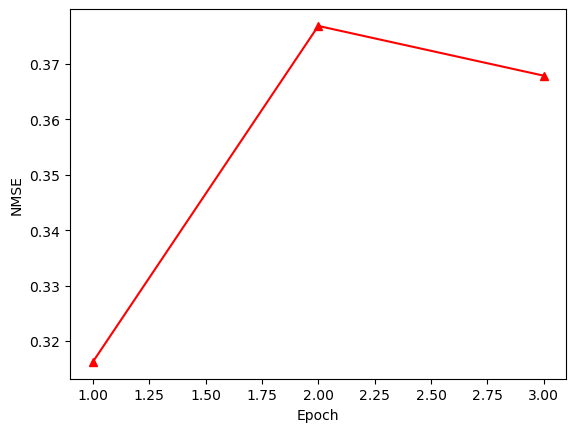

In [14]:
#Execute the training routine
number_of_epochs = 3
nm, ep = train(epochs=number_of_epochs)
if True: #enable to plot NMSE over epochs
    plt.figure()
    plt.plot(ep,nm,'^-r')
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.show();